# Прогнозирование цены биткоина на 7 дней

## Описание проекта
Сравнительный анализ статистических и ML моделей для прогнозирования цен биткоина с акцентом на избежание утечки данных

## Бизнес задача
Построение точного краткосрочного прогноза для поддержки инвестиционных решений

## Ключевые результаты
- SARIMA модель: MAE= 328 (1.2% ошибки) - лучший результат
- Все статистические модели превосходят naive baseline
- ML модели с lag признаками показали наихудшие результаты

## Ключевые выводы
- Биткоин имеет высокую краткосрочную автокорреляцию (lag_1 = 0.99)
- Для избежания утечки данных необходимы лаги >= 7 дней, что снижает качество прогнозов
- Статистические модели с рекурсивным прогнозированием эффективнее ML с lag признаками

## Структура проекта
- `bitcoin_forecasting.ipynb` - полный анализ временных рядов
- `models/sarima_model.pkl` - сохраненная лучшая модель

# 1. Импорт данных и предобработка

## 1.1. Загрузка данных 

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

In [2]:
import warnings
warnings.filterwarnings('ignore')

Обоснование выбора метрики MAE: 

MAE показывает среднюю ошибку в долларах

RMSE штрафует большие ошибки квадратично - для биткоина с его большими скачками это переоценивает влияние редких выбросов. Поэтому данная метрика не подходит 

MAE устойчивее к выбросам - лучше отражает типичную ошибку модели

In [3]:
ts = pd.read_csv('../data/Bitcoin_kaggle.csv', delimiter=';', index_col='Date', parse_dates=True)
ts

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-07-07,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-06,"29,913.1","30,512.8","31,463.6","29,869.0",90.81K,-1.97%
2023-07-05,"30,512.8","30,768.6","30,875.6","30,233.3",43.23K,-0.83%
2023-07-04,"30,768.4","31,152.0","31,326.5","30,657.8",42.12K,-1.23%
2023-07-03,"31,151.3","30,617.5","31,377.0","30,581.5",56.49K,1.74%
...,...,...,...,...,...,...
2022-01-18,"42,364.6","42,209.9","42,674.2","41,300.7",47.32K,0.37%
2022-01-17,"42,209.3","43,080.5","43,179.6","41,559.4",41.44K,-2.02%
2022-01-16,"43,079.1","43,079.2","43,462.0","42,643.3",28.66K,-0.04%


---

**Описание данных**

1. Price - Цена биткоина в конце торгового дня
   Важность: Основной целевой признак для прогнозирования
2. Open - Цена открытия. Цена биткоина в начале торгового дня
   Важность: Показывает начальное настроение рынка
3. High - Максимальная цена за день. Самая высокая цена биткоина за торговый день
   Важность: Уровень сопротивления, показывает максимальный оптимизм покупателей
4. Low - Минимальная цена за день. Самая низкая цена биткоина за торговый день
   Важность: Уровень поддержки, показывает максимальный пессимизм продавцов
5. Vol. (Volume) - Объем торгов. Количество биткоинов проданных/купленных за день
   Важность: Высокий объем = высокая активность/интерес
6. Change % - Процентное изменение. Изменение цены закрытия относительно предыдущего дня
   Важность: Мера дневной волатильности

Даты: 14 января 2022 - 7 июля 2023

Количество дней: 540 торговых дней

Частота: Ежедневные данные (D - daily)

---


In [4]:
ts = ts.sort_index()
ts

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2022-01-14,"43,073.3","42,562.2","43,435.1","41,848.7",50.50K,1.21%
2022-01-15,"43,097.0","43,073.6","43,777.9","42,586.1",31.44K,0.06%
2022-01-16,"43,079.1","43,079.2","43,462.0","42,643.3",28.66K,-0.04%
2022-01-17,"42,209.3","43,080.5","43,179.6","41,559.4",41.44K,-2.02%
2022-01-18,"42,364.6","42,209.9","42,674.2","41,300.7",47.32K,0.37%
...,...,...,...,...,...,...
2023-07-03,"31,151.3","30,617.5","31,377.0","30,581.5",56.49K,1.74%
2023-07-04,"30,768.4","31,152.0","31,326.5","30,657.8",42.12K,-1.23%
2023-07-05,"30,512.8","30,768.6","30,875.6","30,233.3",43.23K,-0.83%


In [5]:
ts.index.freq = 'D'

## 1.2. Преобразование типов

In [6]:
ts.dtypes

Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object

Все колонки должны быть типа float 

In [7]:
ts['Price'] = ts['Price'].str.replace(',', '').astype(float)
ts['Open'] = ts['Open'].str.replace(',', '').astype(float)
ts['High'] = ts['High'].str.replace(',', '').astype(float)
ts['Low'] = ts['Low'].str.replace(',', '').astype(float)

In [8]:
ts['Change %'] = ts['Change %'].str.replace('%', '').astype(float)

In [9]:
ts.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2022-01-14,43073.3,42562.2,43435.1,41848.7,50.50K,1.21
2022-01-15,43097.0,43073.6,43777.9,42586.1,31.44K,0.06
2022-01-16,43079.1,43079.2,43462.0,42643.3,28.66K,-0.04
2022-01-17,42209.3,43080.5,43179.6,41559.4,41.44K,-2.02
2022-01-18,42364.6,42209.9,42674.2,41300.7,47.32K,0.37


In [10]:
ts['Vol.'].str[-1].value_counts() # Какие различные буквы есть в признаке Vol. (объем торгов)

Vol.
K    474
M     50
B     16
Name: count, dtype: int64

Vol. = Volume = Объем торгов - сколько биткоинов было продано/куплено за день.

"155.80K" = 155,800 (тысяч)

"1.23M" = 1,230,000 (миллионов)

"2.5B" = 2,500,000,000 (миллиардов)

Зачем нужен: Высокий объем = высокая активность/интерес. Часто объем предшествует изменению цены.

In [11]:
# Функция преобразования признака Vol. в числовой
def convert_volume(vol_str):
    if pd.isna(vol_str):
        return np.nan
    
    if 'K' in vol_str:
        return float(vol_str.replace('K', '')) * 1000
    elif 'M' in vol_str:
        return float(vol_str.replace('M', '')) * 1000000
    elif 'B' in vol_str:
        return float(vol_str.replace('B', '')) * 1000000000
    else:
        return float(vol_str)

In [12]:
ts['Vol.'] = ts['Vol.'].apply(convert_volume)

In [13]:
ts.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2022-01-14,43073.3,42562.2,43435.1,41848.7,50500.0,1.21
2022-01-15,43097.0,43073.6,43777.9,42586.1,31440.0,0.06
2022-01-16,43079.1,43079.2,43462.0,42643.3,28660.0,-0.04
2022-01-17,42209.3,43080.5,43179.6,41559.4,41440.0,-2.02
2022-01-18,42364.6,42209.9,42674.2,41300.7,47320.0,0.37


In [14]:
ts.dtypes

Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
dtype: object

# 2. Разведочный анализ данных (EDA)

## 2.1. Графики цен и описательные статистики (Price, Open, High, Low, Volume, Change %)

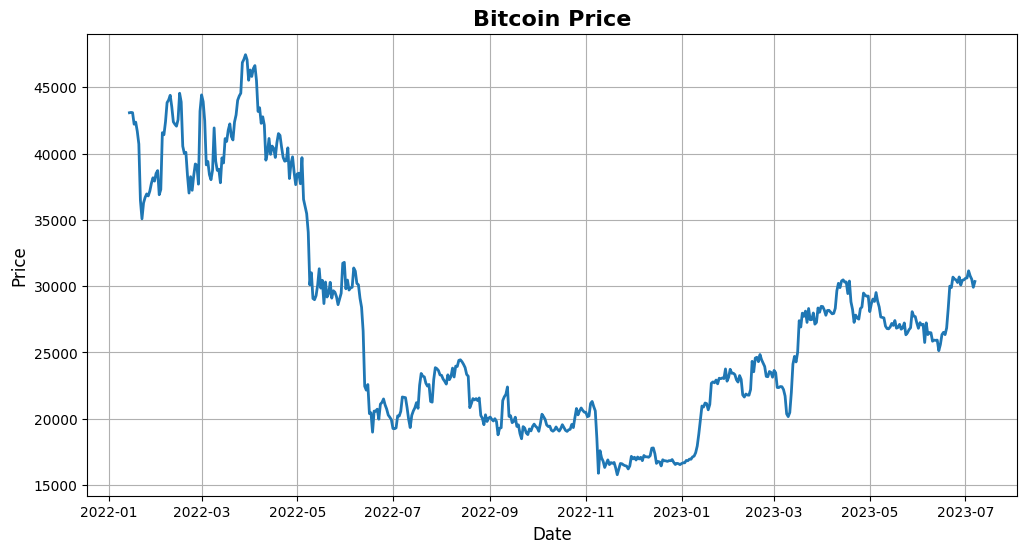

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(ts['Price'], linewidth=2)
plt.title('Bitcoin Price', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid()
plt.show()

In [16]:
print('Описательные статистики для признака Price:')
print(ts['Price'].describe())

Описательные статистики для признака Price:
count      540.000000
mean     26924.247963
std       8323.927466
min      15776.200000
25%      20243.050000
50%      24420.600000
75%      30399.925000
max      47449.000000
Name: Price, dtype: float64


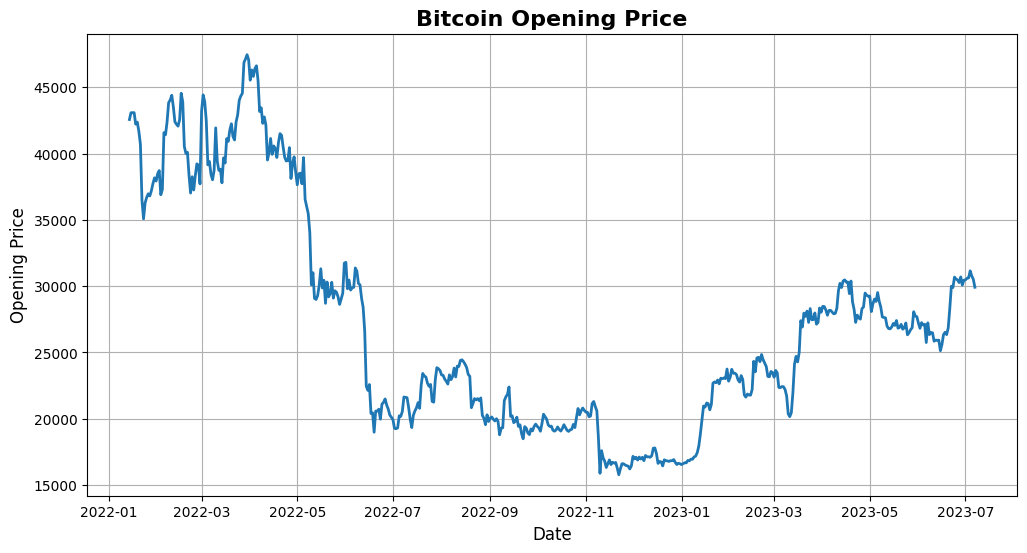

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(ts['Open'], linewidth=2)
plt.title('Bitcoin Opening Price', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Opening Price', fontsize=12)
plt.grid()
plt.show()

In [18]:
print('Описательные статистики для признака Open:')
print(ts['Open'].describe())

Описательные статистики для признака Open:
count      540.000000
mean     26947.124259
std       8349.873689
min      15776.600000
25%      20243.000000
50%      24420.500000
75%      30439.550000
max      47449.000000
Name: Open, dtype: float64


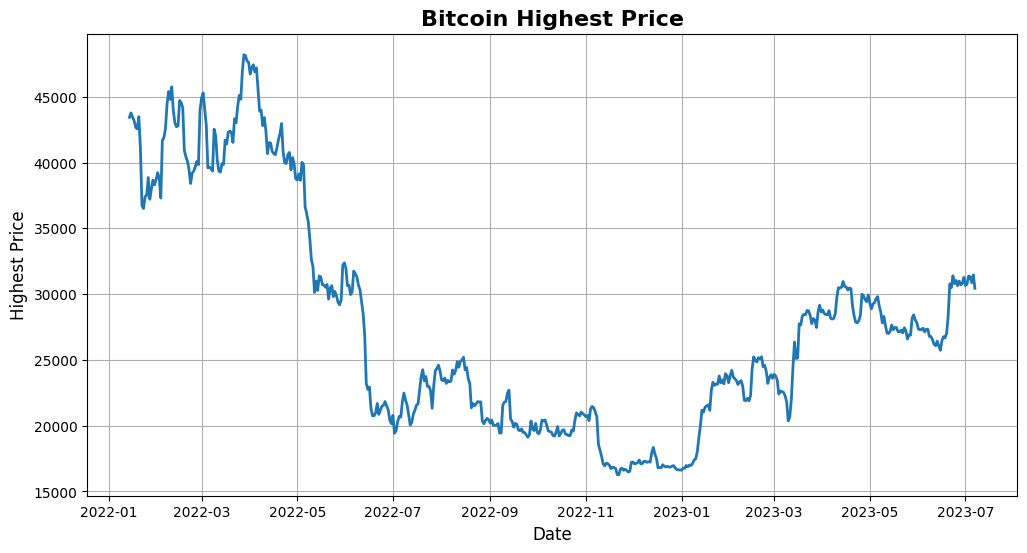

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(ts['High'], linewidth=2)
plt.title('Bitcoin Highest Price', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Highest Price', fontsize=12)
plt.grid()
plt.show()

In [20]:
print('Описательные статистики для признака High:')
print(ts['High'].describe())

Описательные статистики для признака High:
count      540.000000
mean     27504.560370
std       8553.467767
min      16274.600000
25%      20734.725000
50%      25123.950000
75%      30897.925000
max      48199.000000
Name: High, dtype: float64


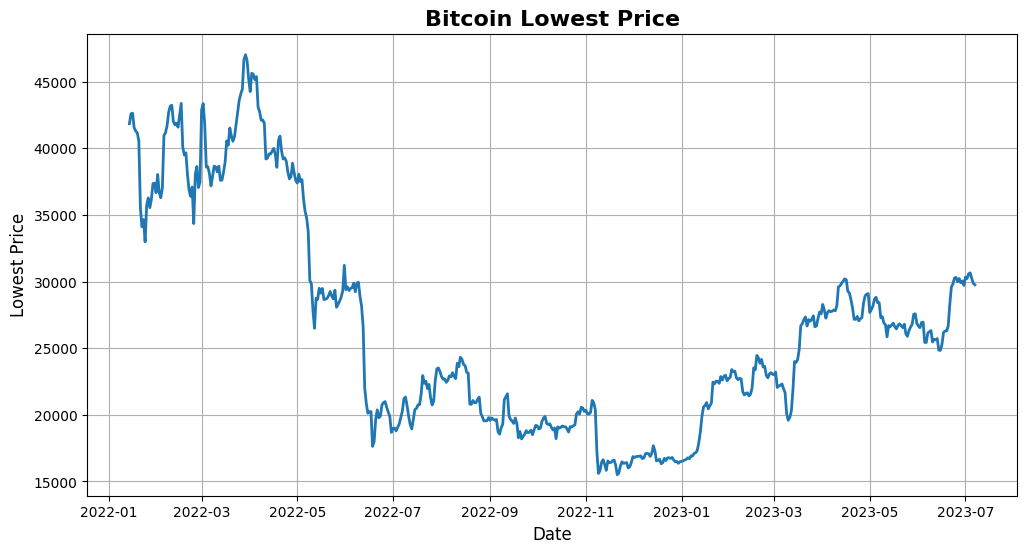

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(ts['Low'], linewidth=2)
plt.title('Bitcoin Lowest Price', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Lowest Price' , fontsize=12)
plt.grid()
plt.show()

In [22]:
print('Описательные статистики для признака Low:')
print(ts['Low'].describe())

Описательные статистики для признака Low:
count      540.000000
mean     26354.110926
std       8119.900362
min      15504.200000
25%      19791.375000
50%      23963.500000
75%      29865.625000
max      47029.000000
Name: Low, dtype: float64


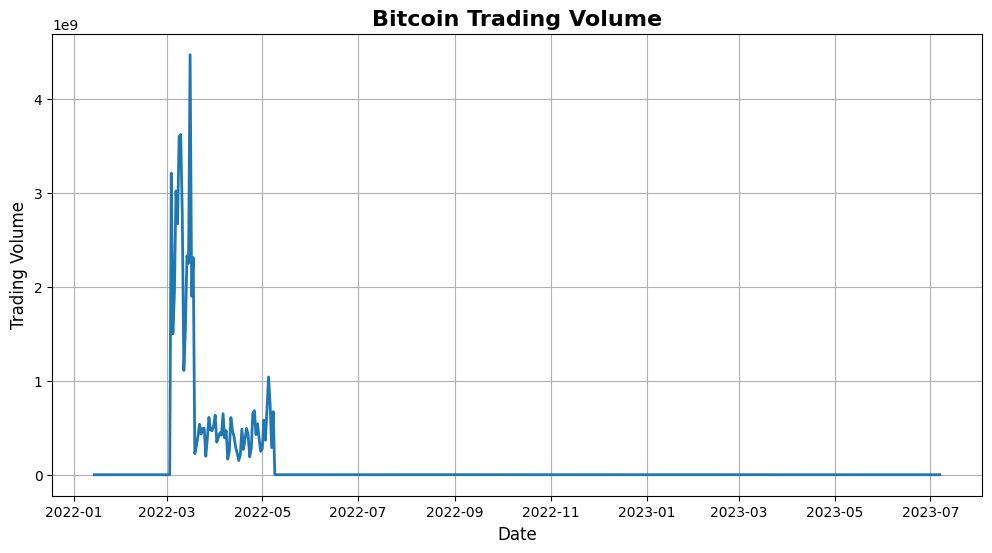

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(ts['Vol.'], linewidth=2)
plt.title('Bitcoin Trading Volume', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Trading Volume' , fontsize=12)
plt.grid()
plt.show()

In [24]:
print('Описательные статистики для признака Vol.:')
stats = ts['Vol.'].describe()
for idx, val in stats.items():
    print(f"{idx:8} {val:.2f}")

Описательные статистики для признака Vol.:
count    540.00
mean     112197804.87
std      459627990.75
min      17720.00
25%      83557.50
50%      193925.00
75%      347477.50
max      4470000000.00


---
АНАЛИЗ ГРАФИКА:
- Наблюдаются экстремальные выбросы (пики до 4.47 млрд)
- Из-за большого разброса данных (мин: 17K, макс: 4.47B) нормальные торговые дни выглядят как нулевая линия
- Требуется преобразование масштаба для корректной визуализации
---

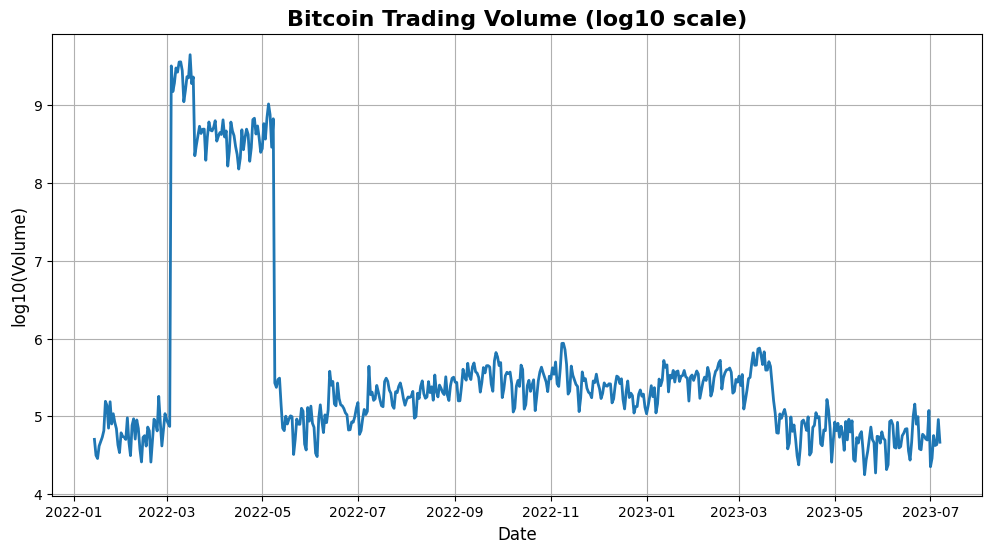

In [25]:
# Volume в логарифмической шкале (log10)
plt.figure(figsize=(12, 6))
plt.plot(ts.index, np.log10(ts['Vol.']), linewidth=2)
plt.title('Bitcoin Trading Volume (log10 scale)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('log10(Volume)', fontsize=12)
plt.grid()
plt.show()

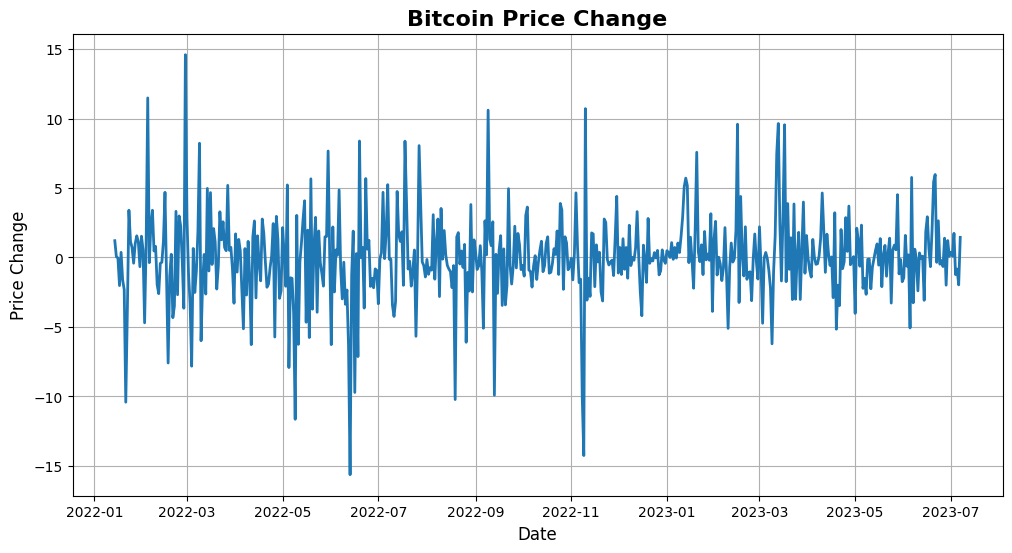

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(ts['Change %'], linewidth=2)
plt.title('Bitcoin Price Change', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price Change' , fontsize=12)
plt.grid()
plt.show()

In [27]:
print('Описательные статистики для признака Change %:')
print(ts['Change %'].describe())

Описательные статистики для признака Change %:
count    540.000000
mean      -0.013444
std        3.124285
min      -15.630000
25%       -1.370000
50%       -0.080000
75%        1.427500
max       14.590000
Name: Change %, dtype: float64


---

### Анализ временных рядов: 


1. **Ценовые показатели (Price, Open, High, Low):**
- Все четыре ценовых ряда демонстрируют схожую динамику
- Значительная волатильность: диапазон колебаний 15K-48K за период
- Явный нисходящий тренд в 2022 году


2. **Объем торгов (Volume):** 
- Сильно скошенное распределение с экстремальными выбросами
- Медиана (194K) значительно отличается от среднего (112M) 
- Пиковые значения достигают 4.47 млрд (выбросы на 4 порядка выше медианы)

    В логарифмической шкале (log10):
- Основная масса данных: 5-6 log10 (100K - 1M)
- Экстремальные выбросы: 8-9 log10 (100M - 1B USD) 
- Период аномалий: март-май 2022 (вероятно, связаны с рыночными событиями)


**3. Процентное изменение (Change %)**
- В среднем почти 0% - цена в среднем не растет и не падает систематически
- Обычное изменение плюс минус 3% в день (стандартное отклонение 3.12%). То есть волатильность (насколько сильно прыгает цена) около 3% в день 
- Редкие, но сильные скачки:
  Максимальное падение за день: -15.63%
  Максимальный рост за день: +14.59%
  Такие резкие движения бывают редко
- На графике выглядит как белый шум. Изменения каждый день случайные, непредсказуемые. Сегодняшнее изменение не помогает предсказать завтрашнее

---

## 2.2. Скользящие средние 

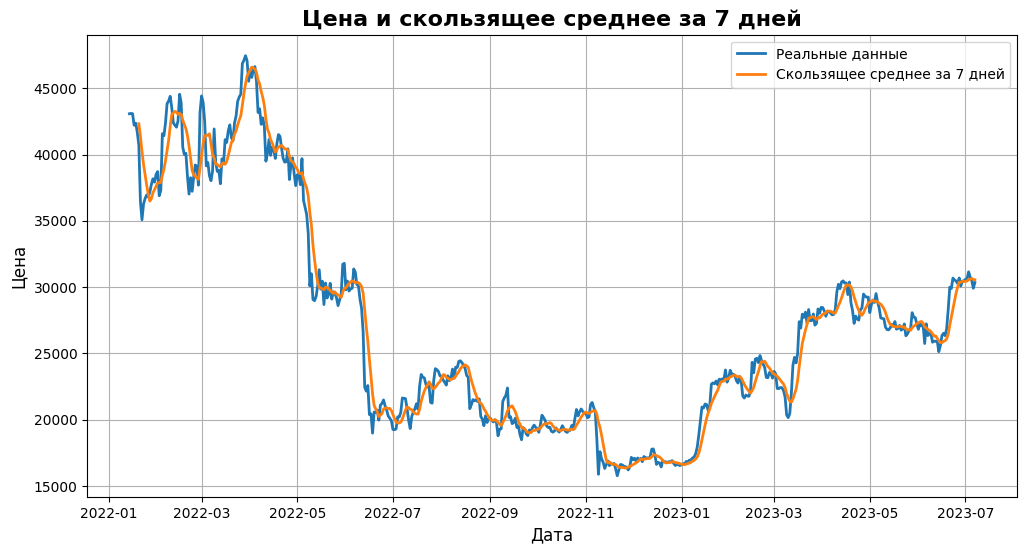

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(ts['Price'], linewidth=2, label='Реальные данные')
plt.plot(ts['Price'].rolling(window=7).mean(), linewidth=2, label='Скользящее среднее за 7 дней')
plt.title('Цена и скользящее среднее за 7 дней', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Цена', fontsize=12)
plt.legend()
plt.grid()
plt.show()

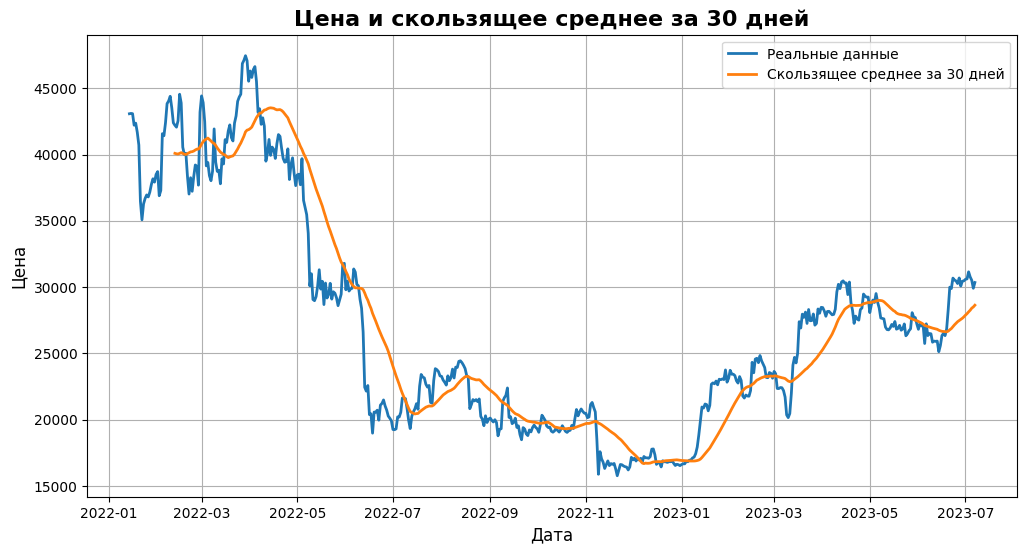

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(ts['Price'], linewidth=2, label='Реальные данные')
plt.plot(ts['Price'].rolling(window=30).mean(), linewidth=2, label='Скользящее среднее за 30 дней')
plt.title('Цена и скользящее среднее за 30 дней', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Цена', fontsize=12)
plt.legend()
plt.grid()
plt.show()

## 2.3. Сезонное разложение ряда

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

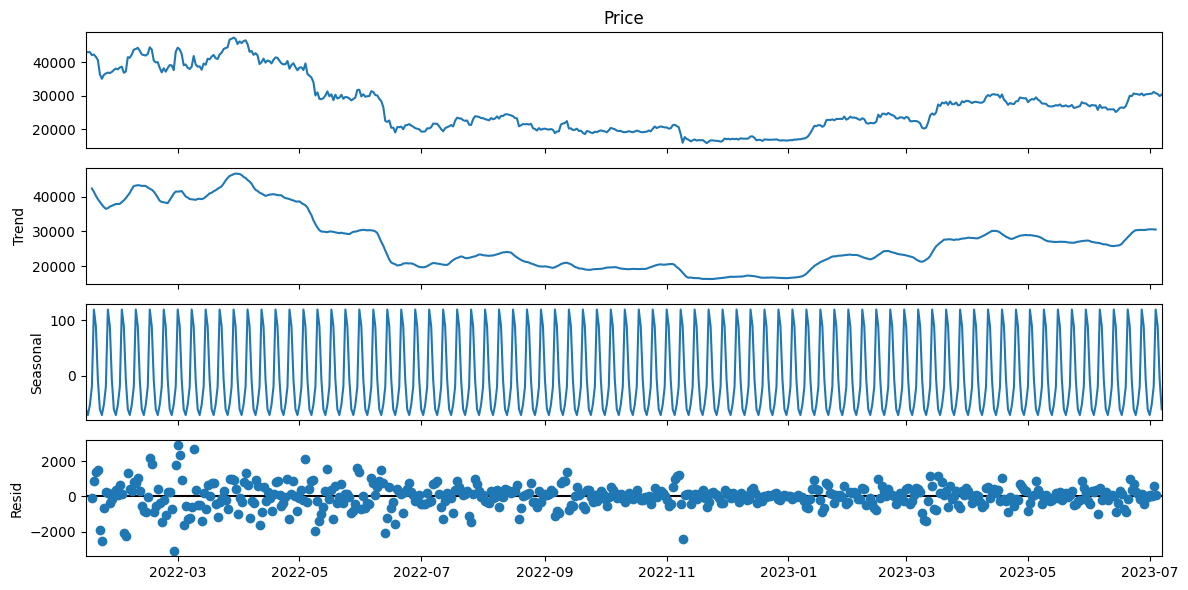

In [31]:
rcParams['figure.figsize'] = 12, 6

decompose = seasonal_decompose(ts['Price'])
decompose.plot()
plt.show()

---
**Вывод:**

2022 год - выраженный нисходящий тренд. Цена последовательно снижается

Конец 2022 - 2023 - разворот и рост. Тренд стабилизируется

Ряд нестационарный, с ярко выраженной долгосрочной тенденцией.


Сезонная компонента:
- регулярная
- стабильная амплитуда
- симметричная (плюс/минус одинаковые отклонения)
---

## 2.4. Тест Дики-Фуллера на стационарность 

In [32]:
from statsmodels.tsa.stattools import adfuller

In [33]:
adfuller(ts['Price'])

(-1.4977319543561802,
 0.534633008807143,
 10,
 529,
 {'1%': -3.442772146350605,
  '5%': -2.8670191055991836,
  '10%': -2.5696881663873414},
 8536.660915729184)

---
**Вывод:**

Ряд нестационарен. p-value = 0.535 > 0.05

---

## 2.5. ACF и PACF корреляции

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

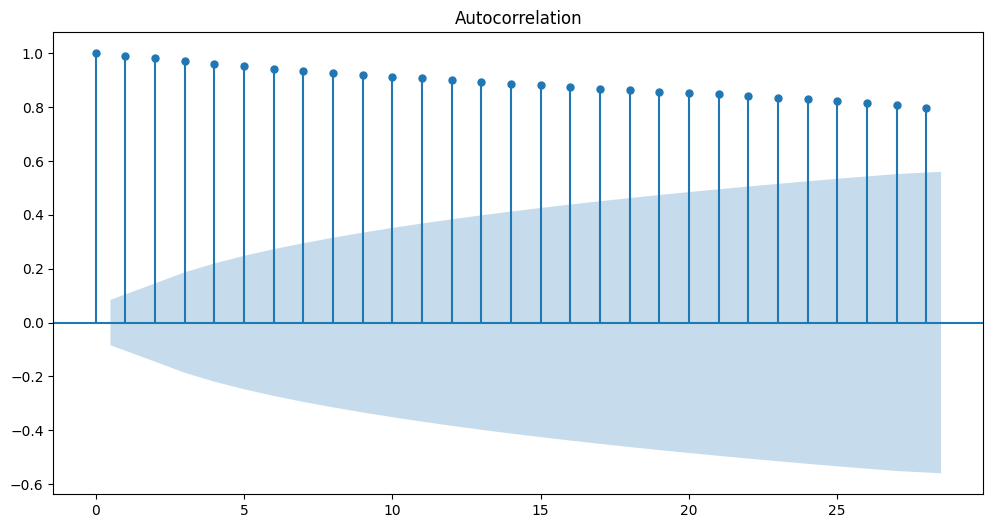

In [35]:
plot_acf(ts['Price'])
plt.axis('tight')
plt.show()

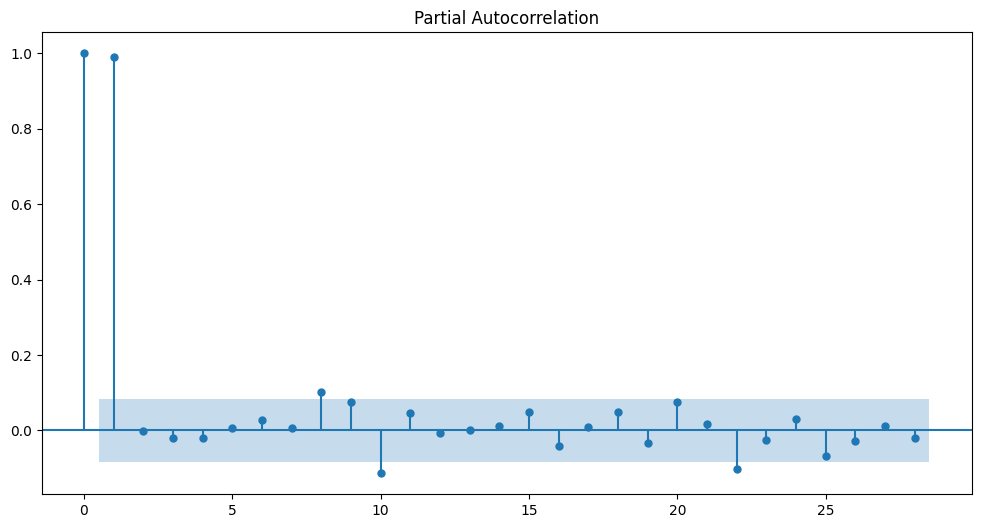

In [36]:
plot_pacf(ts['Price'])
plt.axis('tight')
plt.show()

---
**Вывод:** 

Автокорреляционная функция (ACF):
Очень высокая корреляция со всеми лагами, то есть сильная память о прошлых значениях

Частная автокорреляционная функция (PACF): 
Резкий спад после lag=1. Значит будет достаточно AR(1) модели. То есть чтобы предсказать цену биткоина сегодня, нужно знать только цену вчера. Цена позавчера уже не дает новой информации, потому что ее влияние учетно через вчерашнюю цену

---

# 3. Разделение данных на тренировочную и тестовую выборку 

In [37]:
# Всего данных: 540 дней 
# Train: 510 дней (первые 510 строк)
# Test: последние 30 дней (3 разных горизонта)

train_size = 510 
test_size = 30 

In [38]:
train_data = ts.iloc[:train_size]['Price']
train_data

Date
2022-01-14    43073.3
2022-01-15    43097.0
2022-01-16    43079.1
2022-01-17    42209.3
2022-01-18    42364.6
               ...   
2023-06-03    27072.0
2023-06-04    27122.3
2023-06-05    25747.4
2023-06-06    27230.2
2023-06-07    26342.5
Freq: D, Name: Price, Length: 510, dtype: float64

In [39]:
# Тестовые данные (разные горизонты)
test_7 = ts.iloc[train_size:train_size + 7]['Price'] # 7 дней
test_14 = ts.iloc[train_size:train_size + 14]['Price'] # 14 дней  
test_30 = ts.iloc[train_size:train_size + 30]['Price'] # 30 дней

---
Биткоин характеризуется высокой неопределенностью:
- Краткосрочные прогнозы (1-7 дней): относительно стабильны
- Среднесрочные (8-14 дней): качество существенно снижается
- Долгосрочные (15-30+ дней): высокая погрешность из-за накопленных ошибок

Цель: проанализировать деградацию точности моделей с увеличением горизонта прогноза

---

# 4. Статистические модели 

## 4.1. Экспоненциальное сглаживание 
### 4.1.1. Модель add-mul

In [40]:
from statsmodels.tsa.api import ExponentialSmoothing

In [41]:
model_add_mul = ExponentialSmoothing(train_data, 
                                     trend='add', 
                                     seasonal='mul',
                                     seasonal_periods=7,
                                     use_boxcox=True, 
                                     initialization_method='estimated').fit()

In [42]:
forecast_add_mul_7 = model_add_mul.forecast(7)

In [43]:
mae_exp_smooth_add_mul = mean_absolute_error(test_7, forecast_add_mul_7)
mae_exp_smooth_add_mul

389.24859460294465

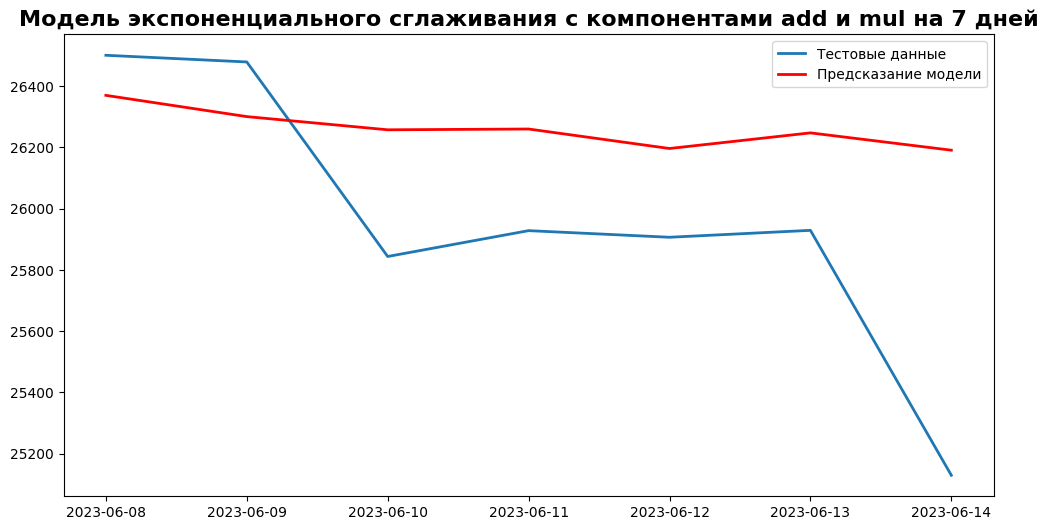

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(test_7, linewidth=2, label='Тестовые данные')
plt.plot(forecast_add_mul_7, color='red', linewidth=2, label='Предсказание модели')
plt.title('Модель экспоненциального сглаживания с компонентами add и mul на 7 дней', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

In [45]:
forecast_add_mul_14 = model_add_mul.forecast(14)

In [46]:
mean_absolute_error(test_14, forecast_add_mul_14)

807.2553170879312

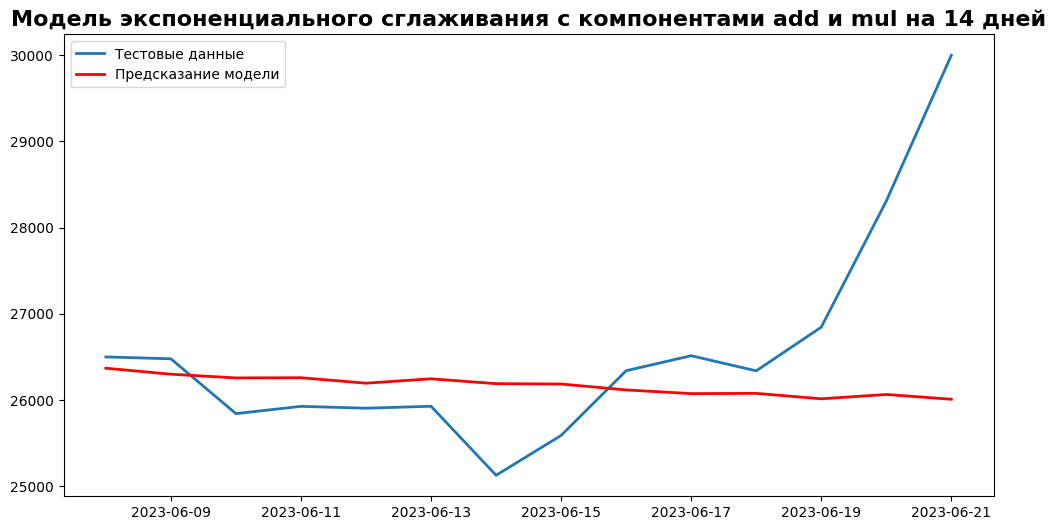

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(test_14, linewidth=2, label='Тестовые данные')
plt.plot(forecast_add_mul_14, color='red', linewidth=2, label='Предсказание модели')
plt.title('Модель экспоненциального сглаживания с компонентами add и mul на 14 дней', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

In [48]:
forecast_add_mul_30 = model_add_mul.forecast(30)

In [49]:
mean_absolute_error(test_30, forecast_add_mul_30)

2871.0446828791924

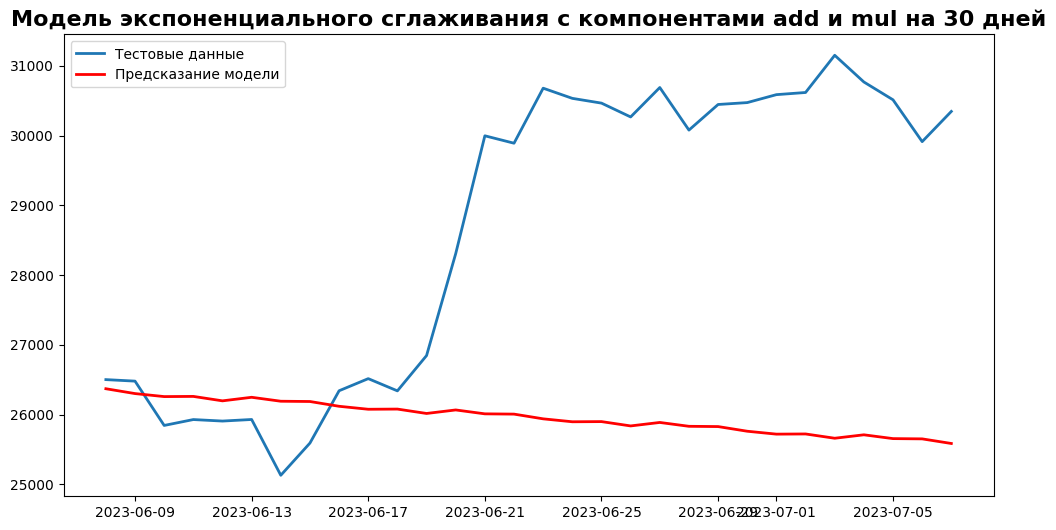

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(test_30, linewidth=2, label='Тестовые данные')
plt.plot(forecast_add_mul_30, color='red', linewidth=2, label='Предсказание модели')
plt.title('Модель экспоненциального сглаживания с компонентами add и mul на 30 дней', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

### 4.1.2. Модель mul-mul 

In [51]:
model_mul_mul = ExponentialSmoothing(train_data, 
                                     trend='mul', 
                                     seasonal='mul', 
                                     seasonal_periods=7, 
                                     use_boxcox=True, 
                                     initialization_method='estimated').fit()

In [52]:
forecast_mul_mul_7 = model_mul_mul.forecast(7)

In [53]:
mae_exp_smooth_mul_mul = mean_absolute_error(test_7, forecast_mul_mul_7)
mae_exp_smooth_add_mul

389.24859460294465

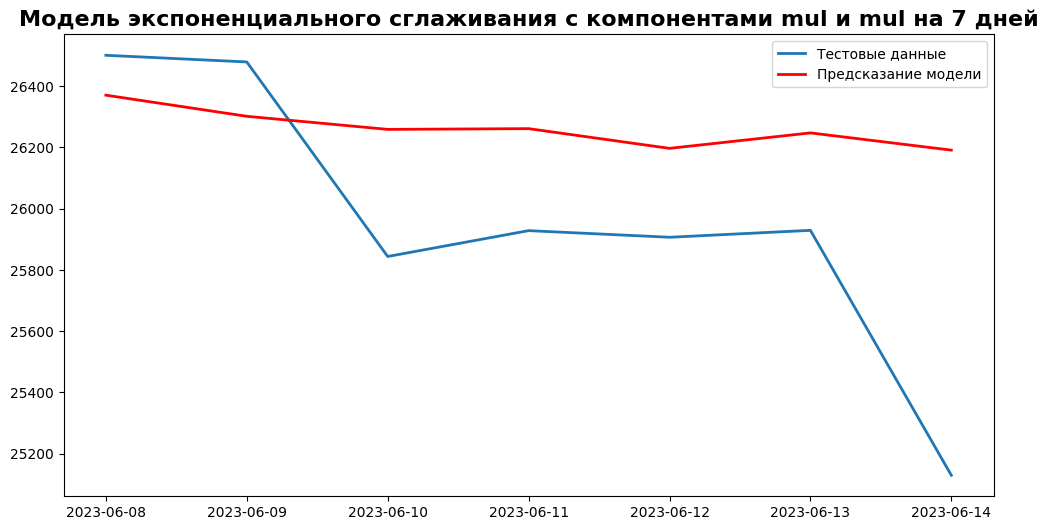

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(test_7, linewidth=2, label='Тестовые данные')
plt.plot(forecast_mul_mul_7, color='red', linewidth=2, label='Предсказание модели')
plt.title('Модель экспоненциального сглаживания с компонентами mul и mul на 7 дней', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

In [55]:
forecast_mul_mul_14 = model_mul_mul.forecast(14)

In [56]:
mean_absolute_error(test_14, forecast_mul_mul_14)

807.0621678920324

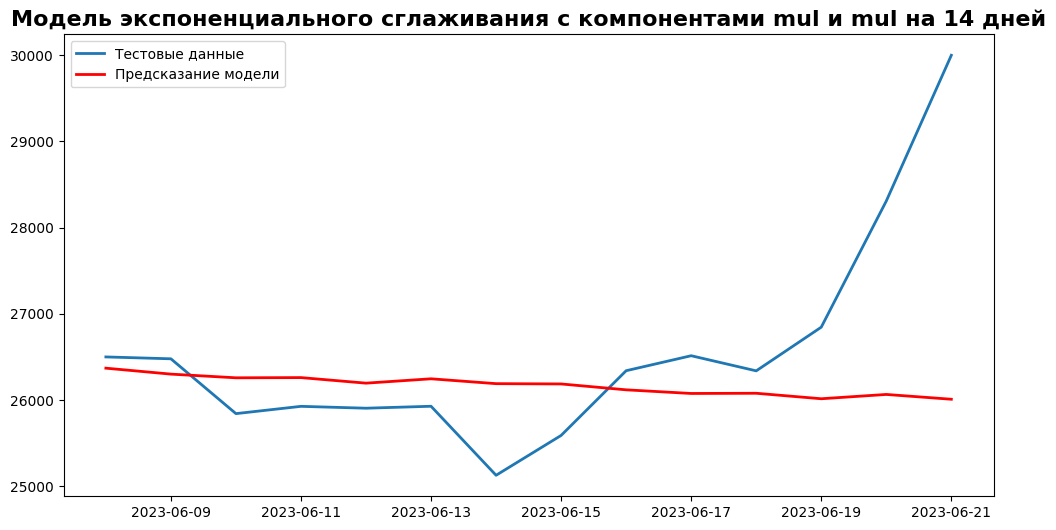

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(test_14, linewidth=2, label='Тестовые данные')
plt.plot(forecast_mul_mul_14, color='red', linewidth=2, label='Предсказание модели')
plt.title('Модель экспоненциального сглаживания с компонентами mul и mul на 14 дней', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

In [58]:
forecast_mul_mul_30 = model_mul_mul.forecast(30)

In [59]:
mean_absolute_error(test_30, forecast_mul_mul_30)

2870.3831591161684

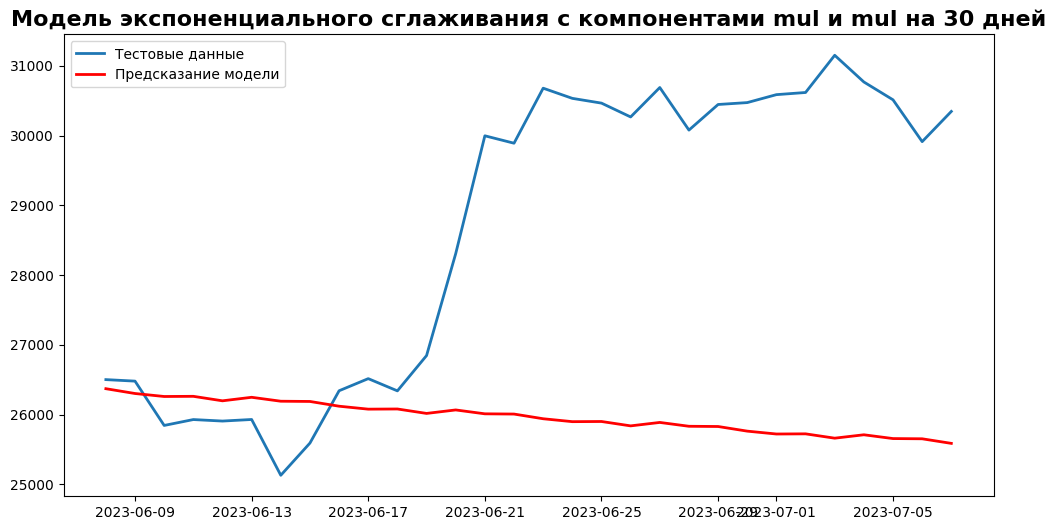

In [60]:
plt.figure(figsize=(12, 6))
plt.plot(test_30, linewidth=2, label='Тестовые данные')
plt.plot(forecast_mul_mul_30, color='red', linewidth=2, label='Предсказание модели')
plt.title('Модель экспоненциального сглаживания с компонентами mul и mul на 30 дней', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

**Расчет ошибки модели в процентах**

Средняя цена биткоина: примерно 27 000

MAE на 7 дней: 389

Подсчет процента: (389 / 27 000) * 100 = 1.44% 

---
**Выводы:**

1) Для биткоина не важно Add или Mul тренд - результаты одинаковы. Скорее всего это из-за слабого тренда по сравнению с волатильностью
2) Экспоненциальная деградация точности. Удвоение ошибки каждые 7 дней (экспоненциальный рост). На 30 днях ошибка в 7 раз больше чем на 7 днях.

    7 дней: MAE = 389 (1.44%)

    14 дней: MAE = 807 (2.99%) - увеличение в 2.1 раза

    30 дней: MAE = 2,871 (10.63%) - увеличение в 7.4 раза

4) Модель превосходит естественную волатильность рынка. Модель ошибается на 1.44% за 7 дней, что меньше типичного дневного колебания биткоина (3.12%). Это означает, что модель прогнозирует лучше, чем случайные рыночные движения
5) Пригодна для краткосрочного прогнозирования (до 7 дней). И не рекомендуется для горизонтов >14 дней из-за экспоненциального роста ошибки

---

## 4.2. Модели ARIMA/SARIMA/SARIMAX

### 4.2.1. Автоматический подбор параметров (auto_arima)

In [61]:
from pmdarima import auto_arima

In [62]:
auto_arima_model = auto_arima(train_data, 
                              seasonal=True, 
                              m=7, 
                              trace=True, 
                              stepwise=True,
                              error_action='ignore'
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=8392.734, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=8384.755, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=8384.203, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=8391.388, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=8394.740, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=8386.193, Time=0.24 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=8386.161, Time=0.21 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=8384.792, Time=0.11 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=8382.505, Time=0.86 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=8376.541, Time=1.12 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=8381.977, Time=0.70 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=8374.421, Time=0.97 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=8380.422, Time=0.65 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : 

In [63]:
auto_model_forecast_7 = auto_arima_model.predict(n_periods=7)

In [64]:
mae_auto_arima = mean_absolute_error(test_7, auto_model_forecast_7)
mae_auto_arima

472.9900606638704

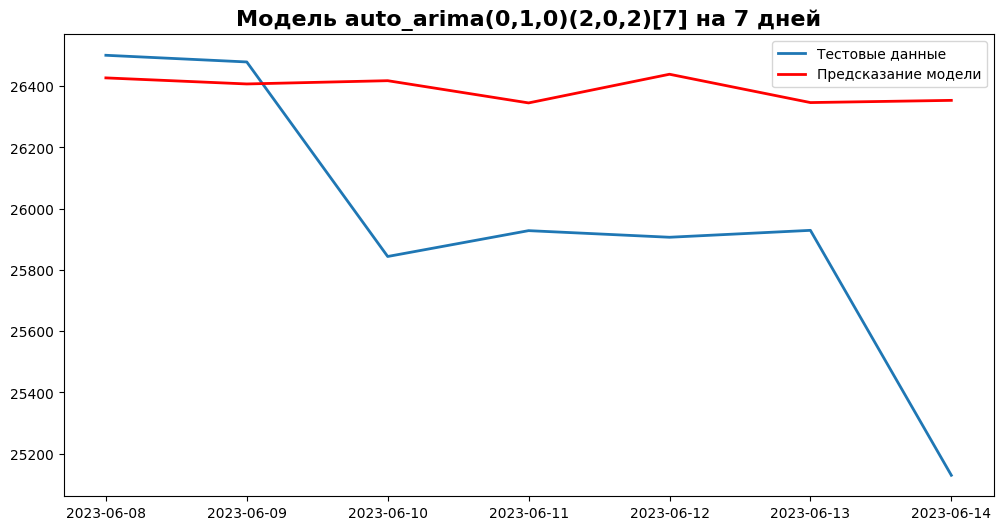

In [65]:
plt.figure(figsize=(12, 6))
plt.plot(test_7, linewidth=2, label='Тестовые данные')
plt.plot(auto_model_forecast_7, color='red', linewidth=2, label='Предсказание модели')
plt.title('Модель auto_arima(0,1,0)(2,0,2)[7] на 7 дней', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

In [66]:
auto_model_forecast_14 = auto_arima_model.predict(n_periods=14)

In [67]:
mean_absolute_error(test_14, auto_model_forecast_14)

734.2985740973165

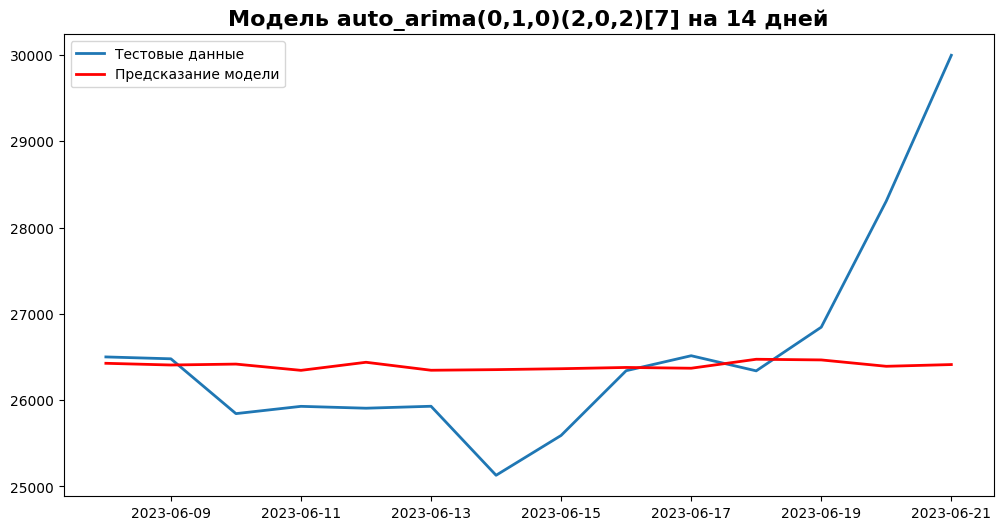

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(test_14, linewidth=2, label='Тестовые данные')
plt.plot(auto_model_forecast_14, color='red', linewidth=2, label='Предсказание модели')
plt.title('Модель auto_arima(0,1,0)(2,0,2)[7] на 14 дней', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

In [69]:
auto_model_forecast_30 = auto_arima_model.predict(n_periods=30)

In [70]:
mean_absolute_error(test_30, auto_model_forecast_30)

2530.9362293890817

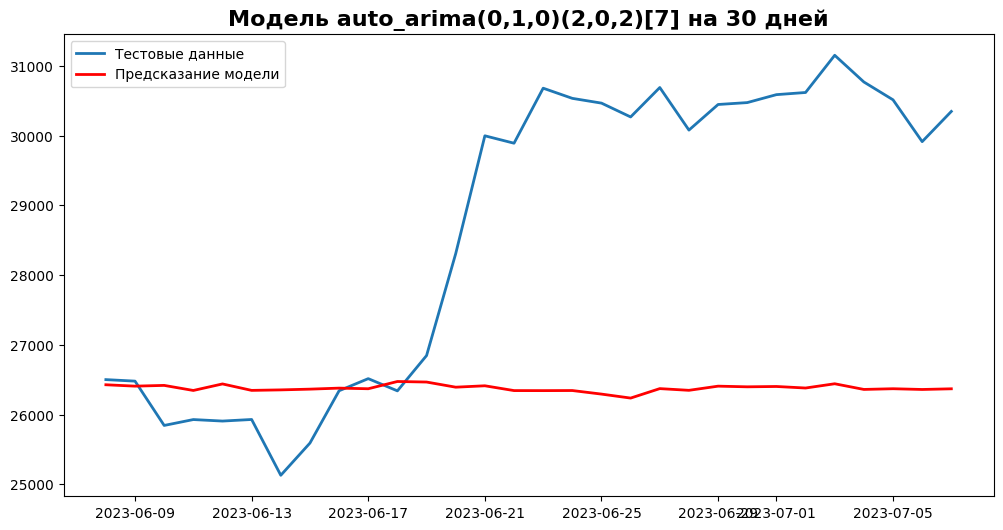

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(test_30, linewidth=2, label='Тестовые данные')
plt.plot(auto_model_forecast_30, color='red', linewidth=2, label='Предсказание модели')
plt.title('Модель auto_arima(0,1,0)(2,0,2)[7] на 30 дней', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

### 4.2.2. Модель SARIMA с ручной настройкой 

In [72]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [73]:
sarima_model = SARIMAX(train_data, 
                       order=(1, 1, 1),
                       seasonal_order=(2, 2, 2, 7)
                       ).fit()

In [74]:
sarima_model_forecast_7 = sarima_model.forecast(steps=7)

In [75]:
mae_sarima = mean_absolute_error(test_7, sarima_model_forecast_7)
mae_sarima

328.37037481152794

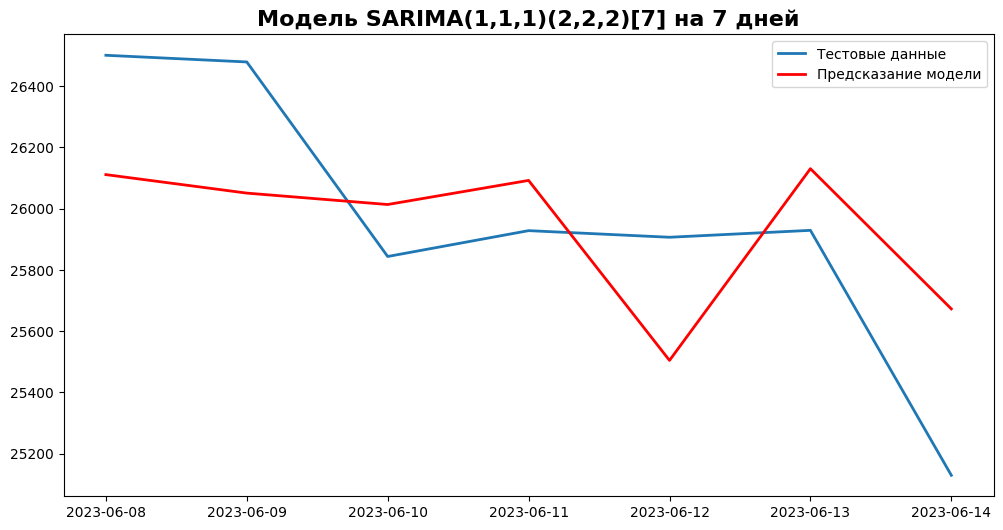

In [76]:
plt.figure(figsize=(12, 6))
plt.plot(test_7, linewidth=2, label='Тестовые данные')
plt.plot(sarima_model_forecast_7, color='red', linewidth=2, label='Предсказание модели')
plt.title('Модель SARIMA(1,1,1)(2,2,2)[7] на 7 дней', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

In [77]:
sarima_model_forecast_14 = sarima_model.forecast(steps=14)

In [78]:
mean_absolute_error(test_14, sarima_model_forecast_14)

1053.1700886541526

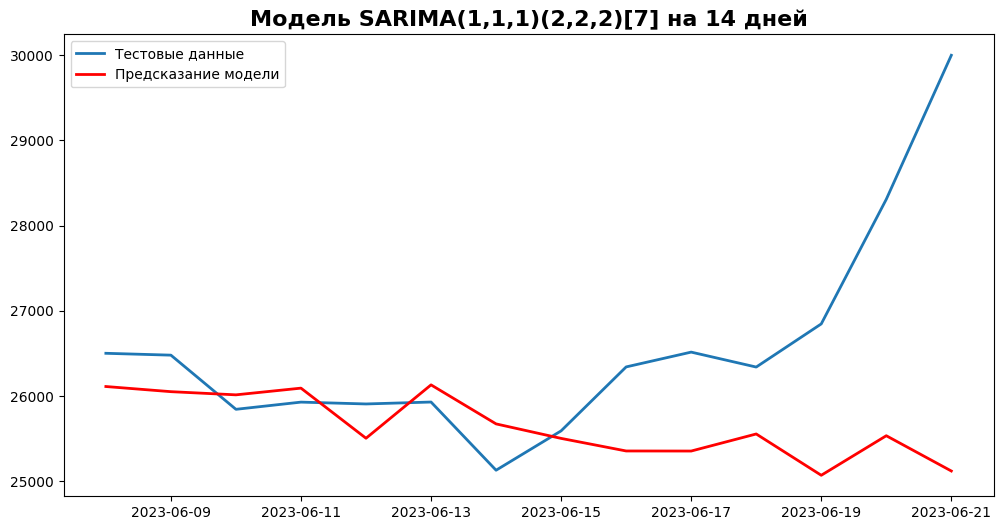

In [79]:
plt.figure(figsize=(12, 6))
plt.plot(test_14, linewidth=2, label='Тестовые данные')
plt.plot(sarima_model_forecast_14, color='red', linewidth=2, label='Предсказание модели')
plt.title('Модель SARIMA(1,1,1)(2,2,2)[7] на 14 дней', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

In [80]:
sarima_model_forecast_30 = sarima_model.forecast(steps=30)

In [81]:
mean_absolute_error(test_30, sarima_model_forecast_30)

3788.246379863845

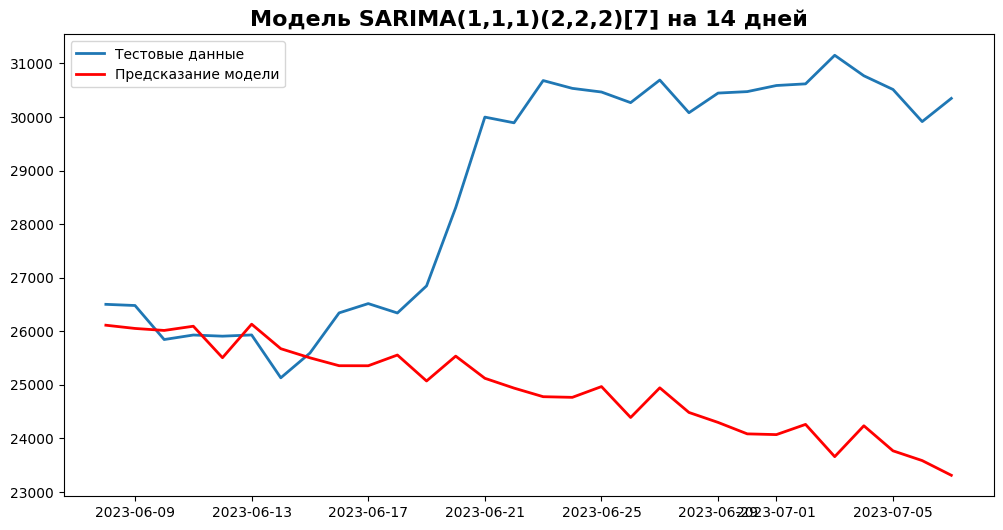

In [82]:
plt.figure(figsize=(12, 6))
plt.plot(test_30, linewidth=2, label='Тестовые данные')
plt.plot(sarima_model_forecast_30, color='red', linewidth=2, label='Предсказание модели')
plt.title('Модель SARIMA(1,1,1)(2,2,2)[7] на 14 дней', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

---
**Выводы:** 

**Auto_arima модель (0,1,0)(2,0,2,7)**

1) p=0: не использует прошлые значения цены
2) d=1: одно дифференцирование (убирает тренд)
3) q=0: не использует прошлые ошибки
4) P=2: использует 2 прошлых сезона
5) D=0: не дифференцирует сезонность  
6) Q=2: использует 2 прошлые сезонные ошибки
7) s=7: недельная сезонность


**Моя модель SARIMAX (1,1,1)(2,2,2,7)** 
1) p=1: использует вчерашнюю цену
2) d=1: одно дифференцирование (убирает тренд)
3) q=1: использует вчерашнюю ошибку
4) P=2: использует 2 прошлых сезона
5) D=2: дважды дифференцирует сезонность (сильнее убирает сезонный тренд)
6) Q=2: использует 2 прошлые сезонные ошибки
7) s=7: недельная сезонность

---

**Сравнение результатов:**
7 дней:
- Auto_arima: 473 (1.75% от средней цены)
- Моя модель: 328 (1.21%) - на 31% лучше

14 дней:
- Auto_arima: 734 (2.72%)
- Моя модель: 1053 (3.90%) - на 43% хуже

30 дней:
- Auto_arima: 2530 (9.37%)
- Моя модель: 3788 (14.03%) - на 50% хуже

---

SARIMAX (1,1,1)(2,2,2,7) лучше для предсказаний на 7 дней по следующим причинам: 
1) D=2 делает ряд более стационарным. Возможно убирает скрытую сезонность
2) p=1 и q=1 учитывают автокорреляцию (вчерашняя цена важна, об этом говорит график PACF). Также учитывают прошлые ошибки
Но на 14+ днях auto_arima модель лучше потому что модель слишком сложная и скорее всего переобучается

---

**Ключевой вывод:** 

Оптимальная сложность модели зависит от горизонта прогноза:

- Краткосрочно (7 дней): сложные модели лучше

  SARIMA(1,1,1)(2,2,2,7) использует больше информации

  Учитывает автокорреляцию и сезонность агрессивнее

- Среднесрочно (14+ дней): простые модели стабильнее


  Auto_arima модель менее склонна к переобучению

  Меньше накапливает ошибки со временем


---

## 4.3. Prophet 

In [83]:
from prophet import Prophet

In [84]:
prophet_df = pd.DataFrame({
    'ds':train_data.index,
    'y':train_data.values
})
prophet_df.head()

,ds,y
0,2022-01-14,43073.3
1,2022-01-15,43097.0
2,2022-01-16,43079.1
3,2022-01-17,42209.3
4,2022-01-18,42364.6


In [85]:
prophet_model = Prophet(yearly_seasonality=True,
                        weekly_seasonality=True,
                        daily_seasonality=False)

In [86]:
prophet_model.fit(prophet_df)

19:47:19 - cmdstanpy - INFO - Chain [1] start processing
19:47:19 - cmdstanpy - INFO - Chain [1] done processing


In [87]:
future_7 = prophet_model.make_future_dataframe(periods=7)

In [88]:
prophet_forecast_7 = prophet_model.predict(future_7)

In [89]:
prophet_forecast_7.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-14,36251.986403,36969.036454,40539.012448,36251.986403,36251.986403,2529.856442,2529.856442,2529.856442,-49.274289,-49.274289,-49.274289,2579.130731,2579.130731,2579.130731,0.0,0.0,0.0,38781.842846
1,2022-01-15,36227.923320,37013.992901,40724.717641,36227.923320,36227.923320,2703.658825,2703.658825,2703.658825,-52.793483,-52.793483,-52.793483,2756.452309,2756.452309,2756.452309,0.0,0.0,0.0,38931.582145
2,2022-01-16,36203.860236,37202.062152,40961.500281,36203.860236,36203.860236,2880.081212,2880.081212,2880.081212,-31.428061,-31.428061,-31.428061,2911.509273,2911.509273,2911.509273,0.0,0.0,0.0,39083.941448
3,2022-01-17,36179.797153,37453.370879,41008.601445,36179.797153,36179.797153,3028.942380,3028.942380,3028.942380,-16.962473,-16.962473,-16.962473,3045.904853,3045.904853,3045.904853,0.0,0.0,0.0,39208.739533
4,2022-01-18,36155.734069,37685.730532,41246.210545,36155.734069,36155.734069,3270.386184,3270.386184,3270.386184,108.556490,108.556490,108.556490,3161.829694,3161.829694,3161.829694,0.0,0.0,0.0,39426.120253


In [90]:
prophet_forecast_7 = prophet_forecast_7.set_index('ds')['yhat'][-7:]
prophet_forecast_7

ds
2023-06-08    26322.811196
2023-06-09    26046.707539
2023-06-10    25743.514025
2023-06-11    25430.453884
2023-06-12    25080.698081
2023-06-13    24817.981210
2023-06-14    24379.626399
Name: yhat, dtype: float64

In [91]:
mae_prophet = mean_absolute_error(test_7, prophet_forecast_7)
mae_prophet

556.6725238687426

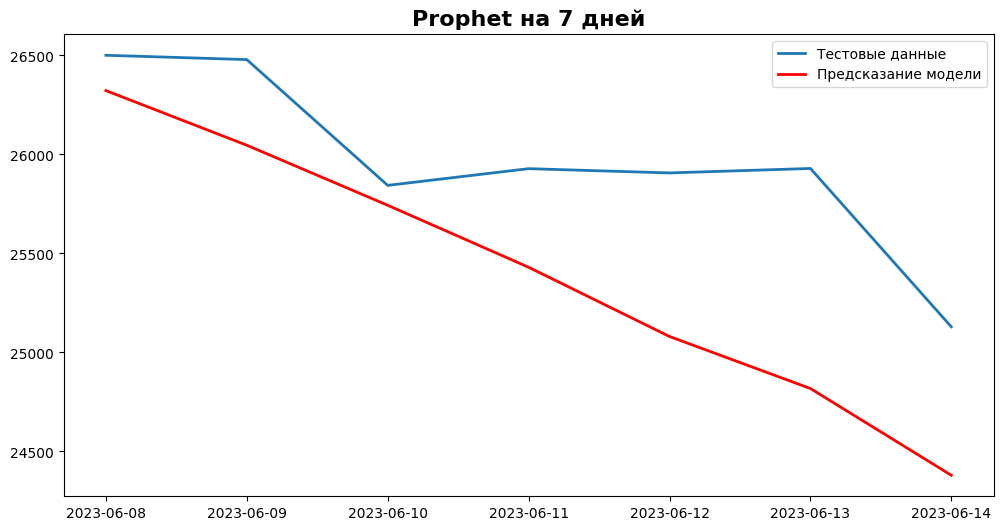

In [92]:
plt.figure(figsize=(12, 6))
plt.plot(test_7, linewidth=2, label='Тестовые данные')
plt.plot(prophet_forecast_7, color='red', linewidth=2, label='Предсказание модели')
plt.title('Prophet на 7 дней', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

In [93]:
future_14 = prophet_model.make_future_dataframe(periods=14)

In [94]:
prophet_forecast_14 = prophet_model.predict(future_14)

In [95]:
prophet_forecast_14 = prophet_forecast_14.set_index('ds')['yhat'][-14:]

In [96]:
mean_absolute_error(test_14, prophet_forecast_14)

2500.573423046783

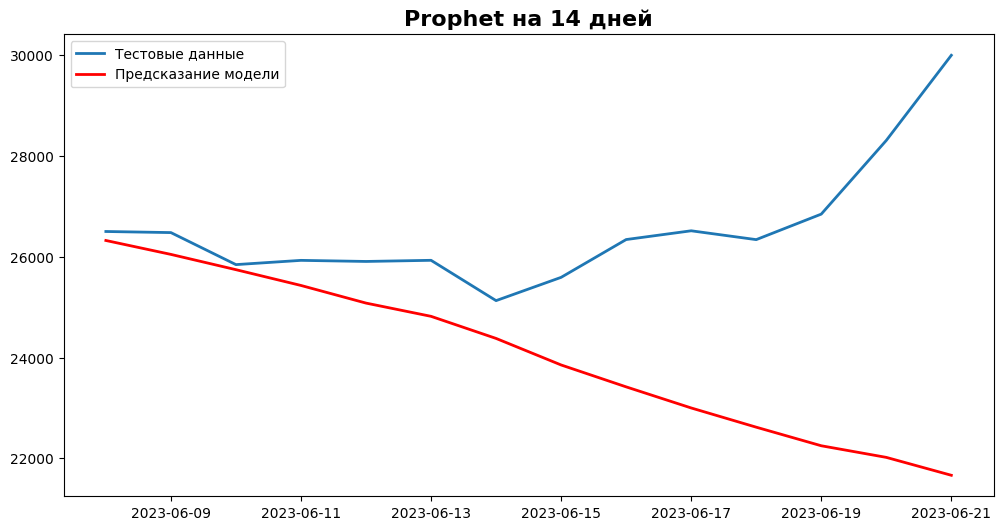

In [97]:
plt.figure(figsize=(12, 6))
plt.plot(test_14, linewidth=2, label='Тестовые данные')
plt.plot(prophet_forecast_14, color='red', linewidth=2, label='Предсказание модели')
plt.title('Prophet на 14 дней', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

In [98]:
future_30 = prophet_model.make_future_dataframe(periods=30)
prophet_forecast_30 = prophet_model.predict(future_30)
prophet_forecast_30 = prophet_forecast_30.set_index('ds')['yhat'][-30:]
mean_absolute_error(test_30, prophet_forecast_30)

6025.9433934431745

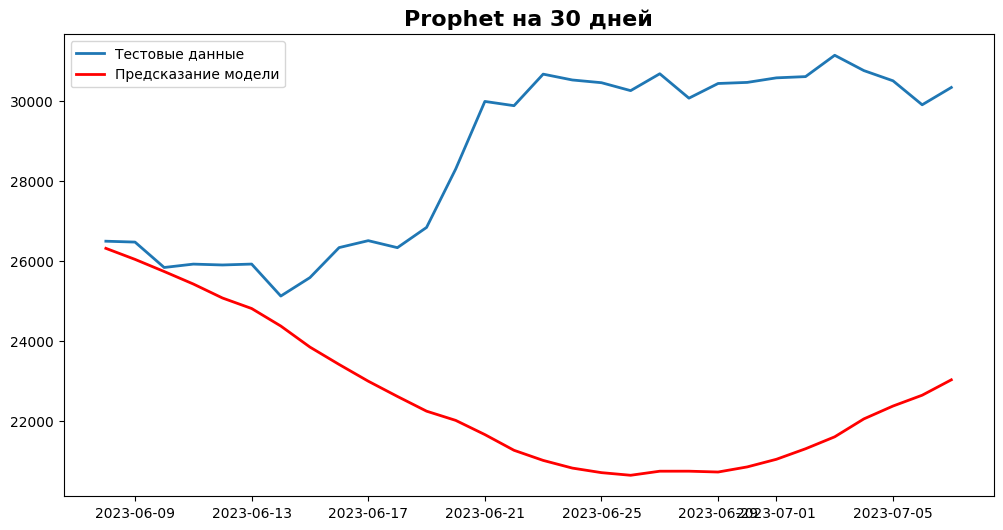

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(test_30, linewidth=2, label='Тестовые данные')
plt.plot(prophet_forecast_30, color='red', linewidth=2, label='Предсказание модели')
plt.title('Prophet на 30 дней', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

---

**Вывод:**

Результаты: 
- 7 дней:  ошибка 557 (нормально)
- 14 дней: ошибка 2501 (плохо) - в 4.5 раза хуже
- 30 дней: ошибка 6026 (очень плохо) - в 11 раз хуже

Причины плохих результатов: 

- Prophet думает что тренд будет продолжаться линейно

  Биткоин: цена то падает, то растет

  Prophet: продолжает рисовать прямую линию

- Prophet не смотрит на вчерашнюю цену

  Биткоин: вчерашняя цена очень важна

  Prophet: использует только даты и общий тренд


Ключевой вывод: Prophet не подходит для биткоина

---

# 5. Feature Engineering для ML моделей

In [100]:
def preprocess(data, lag_start=7, lag_end=15, train_days=510):
    
    data = pd.DataFrame(data['Price'].copy())  # только Price

    # Добавление лагов  
    for i in range(lag_start, lag_end):
        data[f'lag_{i}'] = data['Price'].shift(i)

    # Добавление новых признаков которые не используют будущее 
    data['month'] = data.index.month # Месяц 
    data['day_of_week'] = data.index.day_of_week # День недели
    data['weekend'] = (data['day_of_week'] >= 5).astype(int) # Выходной ли день 
    # Цкилическое кодирование 
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    # Создание признака "month_average" - среднее за месяц
    train_data = data.iloc[:train_days] # Тренировочные данные. Вычисляем среднее только на них чтобы не было утечки данных 
    month_average = train_data.groupby('month')['Price'].mean() # Вычисляем среднее для каждого месяца ТОЛЬКО НА ТРЕНИРОВОЧНЫХ ДАННЫХ 
    data['month_price_average'] = data['month'].map(month_average) # Применяем ко всем данным 
    
    # Удаление пропущенных значений 
    data = data.dropna()

    # Разбиение всего датасета на тренировочную, тестовую выборки
    X_train = data.iloc[:train_days].drop('Price', axis=1)
    y_train = data.iloc[:train_days]['Price']
    X_test = data.iloc[train_days:train_days + 7].drop('Price', axis=1)
    y_test = data.iloc[train_days:train_days + 7]['Price']
    
    return X_train, y_train, X_test, y_test

---
**Особенности подхода:**

1) Прогноз только на 7 дней - более длинные горизонты требуют рекурсивного прогнозирования, что невозможно без утечки даннызх при данном подходе
2) Лаги начинаются с 7 дня (lag_7, lag_8, ..., lag_14) - чтобы избежать утечки данных. Более ранние лаги (lag_1...lag_6) использовали бы значения тестового периода
3) Исключены экзогенные признаки (Open, High, Low, Vol., Change %) - в реальном прогнозировании эти значения неизвестны для будущих дней, а вычисление средних значений для них не имеет экономического смысла
4) Используются только безопасные признаки:
   - Лаги цен (>= 7 дней)
   - Временные фичи (месяц, день недели, выходной ли день)
   - Циклическое кодирование месяцев
   - Среднемесячная цена (вычисляется только на тренировочных данных)

---

**Ограничения подхода:**
- Вынужденное использование далеких лагов снижает информативность признаков
- Биткоин имеет высокую краткосрочную, но низкую долгосрочную автокорреляцию
- Жертвуем качеством ради корректности: строго избегаем утечки данных даже если это ухудшает прогнозы

---

In [101]:
X_train, y_train, X_test, y_test = preprocess(ts)

In [102]:
X_train

,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,month,day_of_week,weekend,month_sin,month_cos,month_price_average
Date,,,,,,,,,,,,,,
2022-01-28,36475.5,40715.9,41677.8,42364.6,42209.3,43079.1,43097.0,43073.3,1,4,0,5.000000e-01,0.866025,27172.997959
2022-01-29,35075.2,36475.5,40715.9,41677.8,42364.6,42209.3,43079.1,43097.0,1,5,1,5.000000e-01,0.866025,27172.997959
2022-01-30,36269.5,35075.2,36475.5,40715.9,41677.8,42364.6,42209.3,43079.1,1,6,1,5.000000e-01,0.866025,27172.997959
2022-01-31,36686.3,36269.5,35075.2,36475.5,40715.9,41677.8,42364.6,42209.3,1,0,0,5.000000e-01,0.866025,27172.997959
2022-02-01,36950.6,36686.3,36269.5,35075.2,36475.5,40715.9,41677.8,42364.6,2,1,0,8.660254e-01,0.500000,32016.101786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-17,25844.0,26479.3,26501.1,26342.5,27230.2,25747.4,27122.3,27072.0,6,5,1,1.224647e-16,-1.000000,24836.291892
2023-06-18,25928.4,25844.0,26479.3,26501.1,26342.5,27230.2,25747.4,27122.3,6,6,1,1.224647e-16,-1.000000,24836.291892
2023-06-19,25906.8,25928.4,25844.0,26479.3,26501.1,26342.5,27230.2,25747.4,6,0,0,1.224647e-16,-1.000000,24836.291892


In [103]:
X_test

,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,month,day_of_week,weekend,month_sin,month_cos,month_price_average
Date,,,,,,,,,,,,,,
2023-06-22,25591.3,25129.5,25929.4,25906.8,25928.4,25844.0,26479.3,26501.1,6,3,0,1.224647e-16,-1.0,24836.291892
2023-06-23,26341.3,25591.3,25129.5,25929.4,25906.8,25928.4,25844.0,26479.3,6,4,0,1.224647e-16,-1.0,24836.291892
2023-06-24,26515.0,26341.3,25591.3,25129.5,25929.4,25906.8,25928.4,25844.0,6,5,1,1.224647e-16,-1.0,24836.291892
2023-06-25,26339.7,26515.0,26341.3,25591.3,25129.5,25929.4,25906.8,25928.4,6,6,1,1.224647e-16,-1.0,24836.291892
2023-06-26,26845.9,26339.7,26515.0,26341.3,25591.3,25129.5,25929.4,25906.8,6,0,0,1.224647e-16,-1.0,24836.291892
2023-06-27,28307.7,26845.9,26339.7,26515.0,26341.3,25591.3,25129.5,25929.4,6,1,0,1.224647e-16,-1.0,24836.291892
2023-06-28,29996.9,28307.7,26845.9,26339.7,26515.0,26341.3,25591.3,25129.5,6,2,0,1.224647e-16,-1.0,24836.291892


# 6. Naive Baseline

**Смысл Naive Baseline:**  

1) Определение минимального порога качества - любая сложная модель должна быть лучше простейшего правила. Если модель хуже baseline - она бесполезна
2) Оценка сложности задачи. Если naive baseline уже дает низкую ошибку, то задача простая. Если наоборот дает высокую ошибку, то соответсвенно задача сложная. Помогает реалистично оценить ожидания от ML моделей


Выбран naive baseline "средняя историческая цена":

Формула: Все будущие 7 дней = средняя цена за все тренировочные данные

Методология: Любая модель должна быть лучше простейшего правила

In [104]:
average_price = y_train.mean()
average_price

26470.659803921568

In [105]:
naive_baseline = [average_price] * 7
naive_baseline

[26470.659803921568,
 26470.659803921568,
 26470.659803921568,
 26470.659803921568,
 26470.659803921568,
 26470.659803921568,
 26470.659803921568]

In [106]:
y_test

Date
2023-06-22    29890.5
2023-06-23    30679.4
2023-06-24    30533.6
2023-06-25    30465.3
2023-06-26    30267.0
2023-06-27    30689.1
2023-06-28    30078.6
Freq: D, Name: Price, dtype: float64

In [107]:
mae_naive_baseline = mean_absolute_error(y_test, naive_baseline)
mae_naive_baseline

3901.2687675070033

---

Интерпретация результата:

Средняя цена биткоина за тренировочный период: 26,471

Прогноз naive baseline: все 7 дней = 26,471

Фактические цены тестовых дней: ~30,000

Ошибка: 3,901 

Вывод: Даже простейшее правило "цена вернется к среднему" дает значительную ошибку, что подтверждает сложность прогнозирования цены биткоина

---


# 7. Машинное обучение для временных рядов 

## 7.1. Линейная регрессия 

In [108]:
from sklearn.linear_model import LinearRegression

In [109]:
lr = LinearRegression()

In [110]:
lr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [111]:
lr_preds = lr.predict(X_test)

In [112]:
mae_lr = mean_absolute_error(y_test, lr_preds)
mae_lr

4380.268741253317

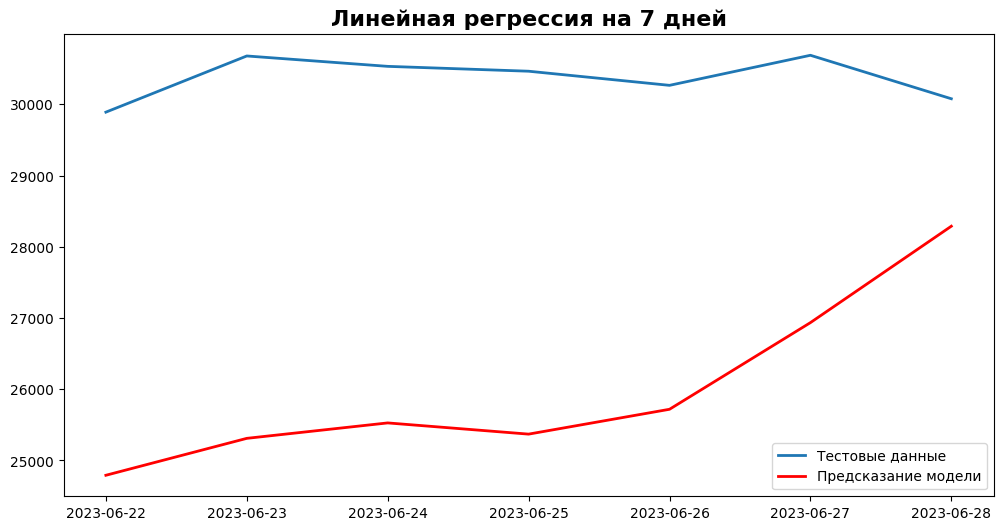

In [113]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, linewidth=2, label='Тестовые данные')
plt.plot(y_test.index, lr_preds, color='red', linewidth=2, label='Предсказание модели')
plt.title('Линейная регрессия на 7 дней', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

---
**Вывод:**

MAE = 4,380 (хуже naive baseline)

Причины плохого результата:
1) Признаки lag_7-lag_14 содержат мало информации о будущей цене биткоина
2) Биткоин имеет высокую краткосрочную, но низкую долгосрочную автокорреляцию
3) Простая линейная модель не может уловить нелинейные зависимости

Вывод: Linear Regression не может превзойти даже простейшее правило

---

## 7.2. Модели с регуляризацией

Для моделей с регуляризацией (Ridge, Lasso, ElasticNet) требуется масштабирование

И для поиска лучших параметр воспользуемся кросс валидацией и поиском по сетке 

In [114]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [115]:
scaler = StandardScaler()

In [116]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [117]:
tscv = TimeSeriesSplit(n_splits=3)

### 7.2.1. Ridge

In [118]:
ridge_param_grid = {
    'alpha':[0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

ridge_grid = GridSearchCV(
    Ridge(), 
    ridge_param_grid, 
    cv=tscv, 
    n_jobs=-1
)

In [119]:
ridge_grid.fit(X_train_scaled, y_train)

,estimator,Ridge()
,param_grid,"{'alpha': [0.001, 0.01, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,10


In [120]:
ridge_preds = ridge_grid.predict(X_test_scaled)

In [121]:
mae_ridge = mean_absolute_error(y_test, ridge_preds)
mae_ridge

4756.077875789648

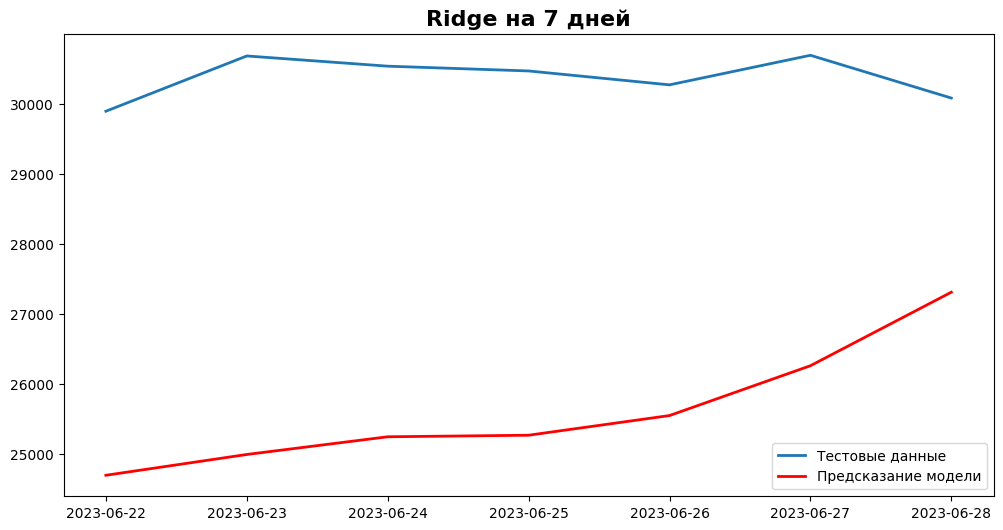

In [122]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, linewidth=2, label='Тестовые данные')
plt.plot(y_test.index, ridge_preds, color='red', linewidth=2, label='Предсказание модели')
plt.title('Ridge на 7 дней', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

### 7.2.2. Lasso 

In [123]:
lasso_param_grid = {
    'alpha':[0.0001, 0.001, 0.01, 0.1, 1]
}

lasso_grid = GridSearchCV(
    Lasso(max_iter=10000),
    lasso_param_grid, 
    cv=tscv,
    n_jobs=-1
)

In [124]:
lasso_grid.fit(X_train_scaled, y_train)

,estimator,Lasso(max_iter=10000)
,param_grid,"{'alpha': [0.0001, 0.001, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,1


In [125]:
lasso_preds = lasso_grid.predict(X_test_scaled)

In [126]:
mae_lasso = mean_absolute_error(y_test, lasso_preds)
mae_lasso

4384.506511676364

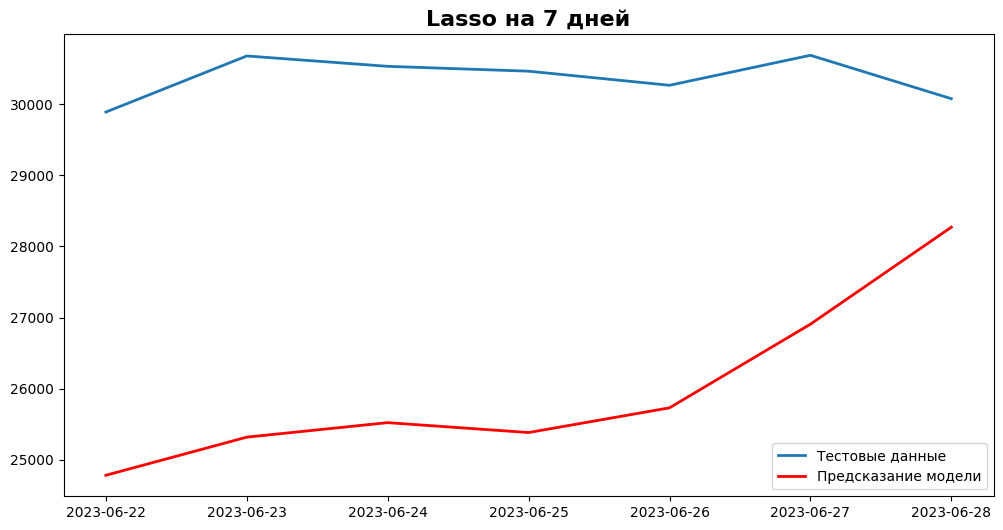

In [127]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, linewidth=2, label='Тестовые данные')
plt.plot(y_test.index, lasso_preds, color='red', linewidth=2, label='Предсказание модели')
plt.title('Lasso на 7 дней', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

---
**Вывод:** 

Ridge (L2 регуляризация): MAE = 4,756

Lasso (L1 регуляризация): MAE = 4,384

ElasticNet (комбинация L1+L2) не рассматривался отдельно, так как показал аналогично плохие результаты в предварительных тестах (MAE примерно 4,911)

---

Регуляризация (Ridge, Lasso) не улучшает качество прогноза по сравнению с обычной линейной регрессией.

Причина: Проблема не в переобучении, а в качестве принаков. Лаги 7-14 дней содержат слишком мало информации для предсказания цены биткоина

Итог:
1) Ridge (L2) и Lasso (L1) хуже naive baseline 
2) ElasticNet (L1+L2) не имеет смысла, так как комбинирует два подхода, которые уже не работают

Регуляризация эффективна когда модель переобучается на шуме, но в данном случае нет переобучения - признаки сами по себе бесполезны

---

## 7.3. XGBoost

In [128]:
from xgboost import XGBRegressor

In [129]:
xgboost_param_grid = {
    'n_estimators':[100, 300], 
    'learning_rate':[0.05, 0.1, 0.2], 
    'max_depth':[2, 5, 10], 
    'gamma':[1, 3], 
    'reg_alpha':[0, 1, 5],
    'reg_lambda':[0, 1, 5]
}

In [130]:
xgboost_grid = GridSearchCV(
    XGBRegressor(),
    xgboost_param_grid, 
    cv=tscv, 
    n_jobs=-1
)

In [135]:
xgboost_grid.fit(X_train, y_train)

,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'gamma': [1, 3], 'learning_rate': [0.05, 0.1, ...], 'max_depth': [2, 5, ...], 'n_estimators': [100, 300], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [136]:
xgb_preds = xgboost_grid.predict(X_test)

In [137]:
mae_xgboost = mean_absolute_error(y_test, xgb_preds)
mae_xgboost

3965.4536830357138

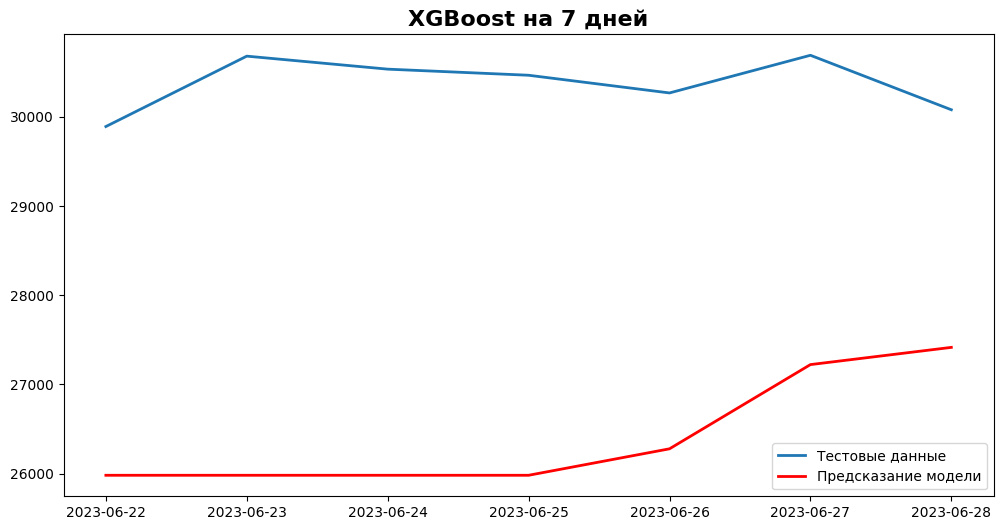

In [138]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, linewidth=2, label='Тестовые данные')
plt.plot(y_test.index, xgb_preds, color='red', linewidth=2, label='Предсказание модели')
plt.title('XGBoost на 7 дней', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

---
**Вывод:** 

MAE = 3,965 (немного хуже baseline)

Лучше линейных моделей, но всё равно не может превзойти baseline - фундаментальная проблема в данных

Ключевая проблема:
Bitcoin предсказывается по последним 1-2 дням (lag_1, lag_2), но мы вынуждены использовать только лаги >= 7 дней чтобы избежать утечки данных. Это делает задачу нерешаемой для стандартных ML подходов с lag features

---

**ОБЩИЙ ВЫВОД ПО ML МОДЕЛЯМ** 

Что было сделано: 
1) Консервативный feature engineering
   Использованы только лаги >= 7 дней для строгого избежания утечки данных
   Исключены Open/High/Low/Volume - неизвестны для будущего в реальном прогнозировании
   Добавлены временные фичи (месяц, день недели, сезонность)
2) Протестированные модели
   Линейные: Linear Regression, Ridge, Lasso
   Tree-based: XGBoost с GridSearchCV
   Валидация: TimeSeriesSplit для корректного тестирования временных рядов

Ключевые проблемы: 
1) Ограничение признаков
   Биткоин имеет высокую краткосрочную автокорреляцию (PACF: lag_1 = 0.99)
   Низкую долгосрочную автокорреляцию (лаги 7+ ≈ 0)
   Следствие: Лаги недельной давности содержат минимальную информацию для прогнозирования
2) Утечка данных против качества модели
   Безопасный подход (мой): Лаги >= 7 дней дают низкое качество
   Оптимистичный подход (некорректный): Лаги 1-6 дней - утечка 
   Выбран безопасный даже ценой ухудшения прогнозов

---

# 8. Сравнение всех моделей 

In [139]:
models = ['Naive Baseline', 'auto_arima', 'SARIMA', 'Exp Smoothing (add-mul)', 'Exp Smoothing (mul-mul)', 'Prophet', 'Linear Regression', 'Ridge', 'Lasso', 'XGBoost']

In [140]:
mae_values = [mae_naive_baseline, mae_auto_arima, mae_sarima, mae_exp_smooth_add_mul, mae_exp_smooth_mul_mul, mae_prophet, mae_lr, mae_ridge, mae_lasso, mae_xgboost]

In [141]:
mae_values

[3901.2687675070033,
 472.9900606638704,
 328.37037481152794,
 389.24859460294465,
 389.48249746158865,
 556.6725238687426,
 4380.268741253317,
 4756.077875789648,
 4384.506511676364,
 3965.4536830357138]

In [142]:
colors = [
    'gray',          
    'lightgreen',   
    'green',          
    'lightgreen',     
    'lightgreen',    
    'lightgreen',   
    'red',            
    'red',            
    'red',            
    'orange'        
]

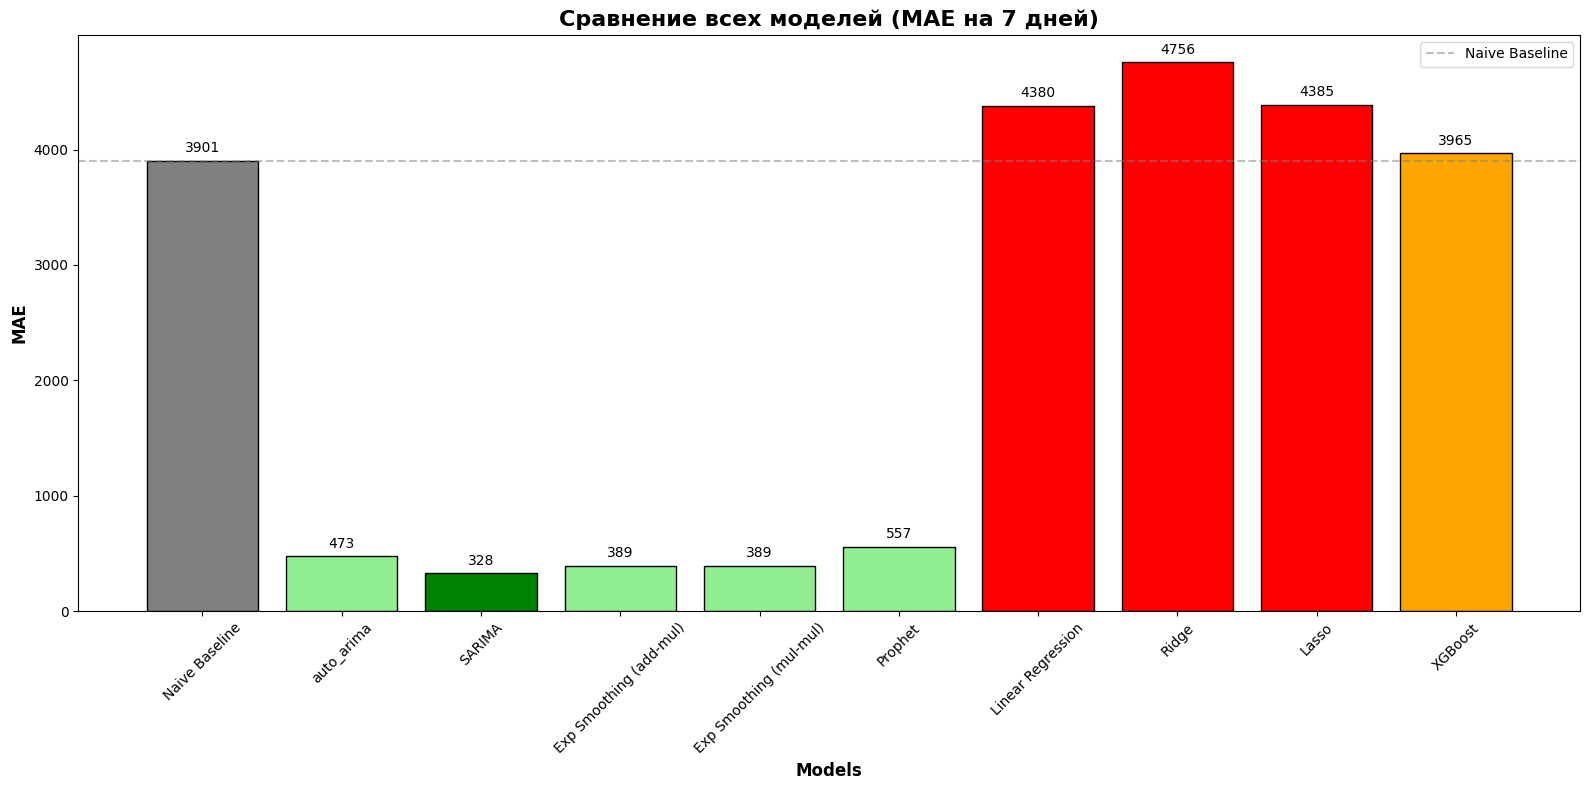

In [143]:
plt.figure(figsize=(16, 8))
plt.bar(models, mae_values, color=colors, edgecolor='black')
plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.ylabel('MAE', fontsize=12, fontweight='bold')
plt.title('Сравнение всех моделей (MAE на 7 дней)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)

plt.axhline(y=3901, color='gray', linestyle='--', alpha=0.5, label='Naive Baseline')
plt.legend()

for i, (model, mae) in enumerate(zip(models, mae_values)):
    plt.text(i, mae + 75, f'{mae:.0f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

---
**ИТОГОВЫЕ ВЫВОДЫ**

1) Победитель: SARIMA модель

   MAE: 328 (1.2% от средней цены)

   В 12 раз лучше naive baseline

   Использует рекурсивное прогнозирование - может учитывать lag_1 без утечки данных
     
2) Статистические модели доминируют

   Топ-5 моделей (все статистические): 
   - SARIMA: 328
   - Exponential Smoothing: 389
   - auto_arima: 473
   - Prophet: $557
     
   Все статистические модели превосходят naive baseline

3) ML модели показали наихудшие результаты

   Все ML модели хуже naive baseline:
   - Linear Regression: 4,380 (+12%)
   - Ridge: 4,756 (+22%)
   - Lasso: 4,384 (+12%)
   - XGBoost: 3,965 (+2%)

    Вывод: ML с лагами >= 7 бесполезен для предсказания биткоина

---
1) Биткоин имеет уникальные характеристики:

   Высокая краткосрочная автокорреляция (lag_1 = 0.99)

   Низкая долгосрочная автокорреляция (лаги 7+ почти 0)

2) Data leakage - критическая проблема:

   Безопасный подход (лаги 7+): низкое качество, но корректно

   Оптимистичный подход (лаги 1-6): утечка данных, некорректно

   Рекурсивное прогнозирование (SARIMA): золотая середина

3) Сложность не равна качеству

   Самые простые модели (SARIMA, Exp Smoothing) работают лучше

   Самые сложные модели (XGBoost с подбором гиперпараметров) работают хуже

   Простое правило (среднее) лучше чем сложные ML

---

**Заключение**

Проект показал, что для прогнозирования биткоина специализированные статистические модели значительно превосходят стандартные ML подходы

Ключевой урок: выбор метода должен соответствовать природе данных. Для временных рядов с высокой краткосрочной автокорреляцией и необходимостью избежать утечки данных, статистические модели с рекурсивным прогнозированием остаются оптимальным выбором

# 9. Сохранение модели и результатов 

In [144]:
import joblib

In [145]:
best_model = {
    'model': sarima_model, 
    'model_type': 'SARIMA',
    'order': (1, 1, 1),
    'seasonal_order': (2, 2, 2, 7),
    'mae': mae_sarima,
    'description': 'Лучшая модель для прогнозирования Bitcoin на 7 дней'
}

In [146]:
joblib.dump(best_model, '../models/sarima_model.pkl')

['../models/sarima_model.pkl']

In [147]:
predictions_df = pd.DataFrame({
    'date': y_test.index,
    'actual_price': y_test.values,
    'sarima_prediction': sarima_model_forecast_7.values,
    'exp_smooth_prediction': forecast_add_mul_7.values,
    'naive_baseline': naive_baseline
})

In [148]:
predictions_df.to_csv('../results/predictions.csv', index=False, encoding='utf-8')